In [83]:
import librosa

In [84]:
# import some libraries you maybe use
import torchvision # an useful library to help I/O (highly recommend). To install this, just do "pip install torchvision"
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
print(np.__version__)
print(torch.__version__)
print(torchvision.__version__)
import os
import visdom
import scipy

1.17.4
1.0.1.post2
0.2.2


In [85]:
batch_size = 320

In [101]:
ROOT_DIR = './results'
TRAINING_NAME = 'resnet50_mag_decay_norm'
OUTPUT_DIR = os.path.join(ROOT_DIR, TRAINING_NAME)
MODEL_PATH = os.path.join(OUTPUT_DIR, 'weight.pth')
ACC_MODEL_PATH = os.path.join(OUTPUT_DIR, 'weight_acc.pth')
RESULT_PATH = os.path.join(OUTPUT_DIR, 'result.csv')
NP_PATH =  os.path.join(OUTPUT_DIR, 'raw_result.npy')

In [87]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Data loading and preprocessing
In order to train the model with training data, the first step is to read the data from your folder, database, etc. The below is just an example.

In [125]:
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize, Normalize
from torch.utils.data import DataLoader
import os
# Define path to your dataset
dataset = "./data" # the root folder
trainpath = os.path.join(dataset,"train") # train set
valpath = os.path.join(dataset,"val") # validation set

cut = lambda x: x[-11025:]
cut_front = lambda x: x[:11025]
norm =  lambda x: (x.astype(np.float32) / (np.max(x)+1e-6))*0.5
spct = lambda x: scipy.signal.spectrogram(x ,fs= 10e3,mode='magnitude')[2] #overlap
tri = lambda x: [x, x, x]
totensor = lambda x: torch.Tensor(x)

tsfm = Compose([
        cut, # rescale to -1 to 1
        norm, # rescale to -1 to 1
        spct, # MFCC 
        tri,
        totensor
        ])

tsfm_front = Compose([
        cut_front, # rescale to -1 to 1
        norm, # rescale to -1 to 1
        spct, # MFCC 
        tri,
        totensor
        ])
nploader = np.load


In [126]:
traindata = DatasetFolder(root=trainpath, loader=nploader, transform=tsfm, extensions=['npy'])
valdata = DatasetFolder(root=valpath, loader=nploader, transform=tsfm_front, extensions=['npy'])

# Create a loader
trainloader = DataLoader(traindata,batch_size=batch_size,shuffle=True, pin_memory=True, num_workers=6)
valloader = DataLoader(valdata,batch_size=batch_size,shuffle=True,  pin_memory=True, num_workers=6)

In [90]:
print(traindata.classes) # show all classes
print(traindata.class_to_idx) # show the mapping from class to index.

['Frog1', 'Frog2', 'Frog3', 'Grylloidea1', 'Grylloidea2', 'Tettigonioidea1', 'Tettigonioidea2', 'drums_FloorTom', 'drums_HiHat', 'drums_Kick', 'drums_MidTom', 'drums_Ride', 'drums_Rim', 'drums_SmallTom', 'drums_Snare', 'guitar_3rd_fret', 'guitar_7th_fret', 'guitar_9th_fret', 'guitar_chord1', 'guitar_chord2']
{'Frog1': 0, 'Frog2': 1, 'Frog3': 2, 'Grylloidea1': 3, 'Grylloidea2': 4, 'Tettigonioidea1': 5, 'Tettigonioidea2': 6, 'drums_FloorTom': 7, 'drums_HiHat': 8, 'drums_Kick': 9, 'drums_MidTom': 10, 'drums_Ride': 11, 'drums_Rim': 12, 'drums_SmallTom': 13, 'drums_Snare': 14, 'guitar_3rd_fret': 15, 'guitar_7th_fret': 16, 'guitar_9th_fret': 17, 'guitar_chord1': 18, 'guitar_chord2': 19}


In [91]:
idx_to_class = {val: key for key, val in traindata.class_to_idx.items()} # build an inverse mapping for later use
print(idx_to_class)

{0: 'Frog1', 1: 'Frog2', 2: 'Frog3', 3: 'Grylloidea1', 4: 'Grylloidea2', 5: 'Tettigonioidea1', 6: 'Tettigonioidea2', 7: 'drums_FloorTom', 8: 'drums_HiHat', 9: 'drums_Kick', 10: 'drums_MidTom', 11: 'drums_Ride', 12: 'drums_Rim', 13: 'drums_SmallTom', 14: 'drums_Snare', 15: 'guitar_3rd_fret', 16: 'guitar_7th_fret', 17: 'guitar_9th_fret', 18: 'guitar_chord1', 19: 'guitar_chord2'}


In [92]:
correct_idx2class = {9: 'Frog1', 10: 'Frog2', 19: 'Frog3', 3: 'Grylloidea1', 14: 'Grylloidea2', 0: 'Tettigonioidea1', 1: 'Tettigonioidea2', 11: 'drums_FloorTom', 5: 'drums_HiHat', 6: 'drums_Kick', 4: 'drums_MidTom', 16: 'drums_Ride', 13: 'drums_Rim', 7: 'drums_SmallTom', 2: 'drums_Snare', 15: 'guitar_3rd_fret', 12: 'guitar_7th_fret', 18: 'guitar_9th_fret', 17: 'guitar_chord1', 8: 'guitar_chord2'}
#print(correct_idx2class)

In [93]:
correct_class2idx = {val: key for key, val in correct_idx2class.items()}
#print(correct_class2idx)

In [94]:
corrected_idx2idx = {val: correct_class2idx[key] for key, val in traindata.class_to_idx.items()}
print(corrected_idx2idx)

{0: 9, 1: 10, 2: 19, 3: 3, 4: 14, 5: 0, 6: 1, 7: 11, 8: 5, 9: 6, 10: 4, 11: 16, 12: 13, 13: 7, 14: 2, 15: 15, 16: 12, 17: 18, 18: 17, 19: 8}


# Build an example network
If you're unfamiliar with this part, please see the HW1 tutorial.

In [95]:
import utils.resnet as resnet
model =resnet.resnet50(num_classes= len(traindata.classes))

In [96]:
class Net(nn.Module):
    def __init__(self,num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        #out = out.view(out.size(0), -1)
        
        out  = F.interpolate(out, size=(5, 5), mode='bilinear')  # resize to the size expected by the linear unit
        out = out.view(out.size(0), 5 * 5 * 16)

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [97]:
net = Net(num_classes=len(traindata.classes)) # initialize your network
net = model
# Whether to use GPU or not?
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'
print("use",device,"now!")
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01) # setup your optimizer
#optimizer = optim.SGD(net.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss() # setup your criterion

lambda1 = lambda epoch: epoch // 15
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #0.1->0.8

use cuda now!


# Train the model with the data

In [98]:
def save_model(model,filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)
#save_model(net,"weight.pth")


In [99]:
import utils.visdoms as visdoms
plotter = visdoms.VisdomLinePlotter(env_name=TRAINING_NAME)

Setting up a new session...


In [ ]:
net.train()
num_epoch = 100
best_loss = 1e8
best_acc = 0
train_losses = visdoms.AverageMeter()
val_losses = visdoms.AverageMeter()
for epoch in range(num_epoch):
    #net.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        #print(data.shape,target)
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        train_losses.update(loss.data.cpu().numpy(), target.size(0))
        loss.backward()
        optimizer.step()
        print('.',  end='')
    scheduler.step()
        
        
    plotter.plot('loss', 'train', 'Class Loss', epoch, train_losses.avg)
    
    net.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valloader):
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = net(data)
            val_loss = criterion(output, target)
            val_losses.update(val_loss.data.cpu().numpy(), target.size(0))
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            print('.',  end='')
        acc = correct.item() / len(valloader.dataset)
        print("Val Acc: %f"%(acc))

        plotter.plot('loss', 'val', 'Class Loss', epoch, val_losses.avg)
        plotter.plot('acc', 'val', 'Class Accuracy', epoch, acc)
            
        print('epoch %d, lr %.6f, loss: %.4f, val_loss: %.4f' %(epoch+1, optimizer.param_groups[0]['lr'], loss.item(), val_loss.item()))
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            save_model(net, MODEL_PATH)
        if acc > best_acc:
            best_acc = acc
            save_model(net, ACC_MODEL_PATH)
    
    

..........................................Val Acc: 0.054647
epoch 1, lr 0.010000, loss: 1.5029, val_loss: 4.5162
..........................................Val Acc: 0.082616
epoch 2, lr 0.010000, loss: 2.7956, val_loss: 2.7272
..........................................Val Acc: 0.088640
epoch 3, lr 0.010000, loss: 2.7771, val_loss: 2.8580
..........................................Val Acc: 0.219880
epoch 4, lr 0.010000, loss: 2.3458, val_loss: 2.3786
..........................................Val Acc: 0.334337
epoch 5, lr 0.010000, loss: 1.8567, val_loss: 2.0515
..........................................Val Acc: 0.472031
epoch 6, lr 0.010000, loss: 1.3762, val_loss: 1.8493
..........................................Val Acc: 0.581756
epoch 7, lr 0.010000, loss: 0.9436, val_loss: 1.1201
..........................................Val Acc: 0.710843
epoch 8, lr 0.010000, loss: 0.5798, val_loss: 1.0488
..........................................Val Acc: 0.798623
epoch 9, lr 0.010000, loss: 0.3210, 

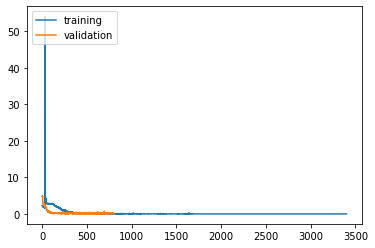

In [120]:

from matplotlib import pyplot as plt
plt.plot(train_losses.arr)
plt.plot(val_losses.arr)
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

# Save model

# Load model

In [121]:
def load_model(model,filename):
    model.load_state_dict(torch.load(filename))
    return model
net = Net(num_classes=len(traindata.classes)) # initialize your network
net = model
net = load_model(net, MODEL_PATH)
# Whether to use GPU or not?
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'
print("use",device,"now!")
net.to(device)

use cuda now!


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Evaluate on validation data

In [127]:
net.eval()
correct = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(valloader):
        #print(type(data))
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    acc = correct.item() / len(valloader.dataset)
print("Validation Classification Accuracy: %f"%(acc))

Validation Classification Accuracy: 0.981928


# Loading Testing Data

In [124]:
test_data = np.load('./data/test.npy', allow_pickle=True)
print(len(test_data))

2387


In [128]:
t_spec = []
for t in test_data:
    test = cut_front(t)
    test = norm(test)
    test = spct(test) 
    test = tri(test)
    test = totensor(test)
    t_spec.append(test)

In [129]:
print(type(test))
print(type(test.data))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [130]:
tensor_x = torch.stack(t_spec)

In [131]:
tensor_x[0][0][0][0]

tensor(0.0017)

In [132]:
test_dataset = torch.utils.data.TensorDataset(tensor_x) # create your datset
test_dataloader = torch.utils.data.DataLoader(test_dataset) # create your dataloader

In [ ]:
net.eval()
result = []
raw_result = []
with torch.no_grad():
    for batch_idx, (data, ) in enumerate(test_dataloader):  
        data = data.to(device)
        #target = target.to(device)
        output = net(data)
        pred = output.data.max(1, keepdim=True)[1]
        #correct += pred.eq(target.data.view_as(pred)).sum()
        result = result + list(pred.cpu().numpy().ravel())
        raw_result.append(list(output.cpu().numpy().ravel()))
    #acc = correct.item() / len(valloader.dataset)
#print("Validation Classification Accuracy: %f"%(acc))

In [ ]:
output

In [ ]:
np.save(NP_PATH, np.asarray(raw_result))

In [ ]:
result = [corrected_idx2idx[idx] for idx in result]

In [ ]:
df_dict = {'id': list(range(0 ,len(test_data))), 'category':result}

In [ ]:
import pandas as pd
df = pd.DataFrame(df_dict)

In [ ]:
df.head()

In [ ]:
df.to_csv(RESULT_PATH, index=False)